This notebook demonstrates using the Fisher Information to calculate generalisability and trainability metrics

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL

from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser as ConfigParser

import utils
# Ipmport various network architectures
from networks import AGRadGalNet, VanillaLeNet, testNet, DNSteerableLeNet, DNSteerableAGRadGalNet
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest
import torch.nn.functional as F

Load in the dataset and the relevant configuration

In [2]:

PATH = "configs/"
cfg_base = "C4_attention_mirabest.cfg"
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(PATH + cfg_base)
device = "cuda"

train_loader, valid_loader  = utils.data.load(
    config, 
    train=True, 
    augmentation='config', 
    data_loader=True
)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Files already downloaded and verified


/raid/scratch/mattyb/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


In [3]:
print(f"Loading in {config['model']['base']}")
net = locals()[config['model']['base']](**config['model']).to(device)

quiet = config.getboolean('DEFAULT', 'quiet')
early_stopping = config.getboolean('training', 'early_stopping')

# Read / Create Folder for Data to be Saved
root = config['data']['directory']
os.makedirs(root, exist_ok=True)

if not quiet:
    if 'DN' not in config['model']['base']:
        summary(net, (1, 150, 150))
    print(device)
    if device == torch.device('cuda'):
        summary(net, (1,150,150))
        print(torch.cuda.get_device_name(device=device))

Loading in DNSteerableAGRadGalNet


/raid/scratch/mattyb/venv/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  sampled_basis = sampled_basis[mask, ...]


cuda


Attempt to load in the best saved model

In [4]:
path_supliment = config['data']['augment']+'/'
model = utils.utils.load_model(config, load_model='best', device=device, path_supliment=path_supliment)

Save the Model Weights and then Train the Last Layer to ensure the grad information is retained

In [5]:
Conv1a = model.conv1a.weights
Conv1b = model.conv1b.weights
Conv1c = model.conv1c.weights
Conv2a = model.conv2a.weights
Conv2b = model.conv2b.weights
Conv2c = model.conv2c.weights
Conv3a = model.conv3a.weights
Conv3b = model.conv3b.weights
Conv3c = model.conv3c.weights
Conv4a = model.conv4a.weights
Conv4b = model.conv4b.weights
Psi1 = model.attention1.psi.weight
Psi2 = model.attention2.psi.weight
Psi3 = model.attention3.psi.weight
Theta1 = model.attention1.theta.weight
Theta2 = model.attention2.theta.weight
Theta3 = model.attention3.theta.weight
Phi1 = model.attention1.phi.weight
Phi2 = model.attention2.phi.weight
Phi3 = model.attention3.phi.weight
del(model)

In [6]:

net.conv1a.weights=Conv1a 
net.conv1b.weights=Conv1b 
net.conv1c.weights=Conv1c 
net.conv2a.weights=Conv2a 
net.conv2b.weights=Conv2b 
net.conv2c.weights=Conv2c 
net.conv3a.weights=Conv3a 
net.conv3b.weights=Conv3b 
net.conv3c.weights=Conv3c 
net.conv4a.weights=Conv4a 
net.conv4b.weights=Conv4b 
net.attention1.psi.weight=Psi1  
net.attention2.psi.weight=Psi2  
net.attention3.psi.weight=Psi3 
net.attention1.theta.weight=Theta1 
net.attention2.theta.weight=Theta2 
net.attention3.theta.weight=Theta3 
net.attention1.phi.weight=Phi1 
net.attention2.phi.weight=Phi2 
net.attention3.phi.weight=Phi3


for name, param in net.named_parameters():
    param.requires_grad=False

net.classifier.weight.requires_grad=True


Test a Simplified Version of the Training Cycle

In [7]:
def train(net, 
          device, 
          config,
          Epoch,
          train_loader,
          optimizer,
          root_out_directory_addition='',
          scheduler = None,
          save_validation_updates=True,
          class_splitting_index=1,
          loss_function = nn.CrossEntropyLoss(),
          output_model=True,
          early_stopping=True,
          output_best_validation=False,
          stop_after_epochs_without_update=2000
         ):
    """Very Simple version of the training loop used in the train.py file to try and find approximate
    gradients of the Classifier Layer
    """
    # -----------------------------------------------------------------------------
    # Initialise Seeds
    torch.manual_seed(42)
    np.random.seed(42)
    # -----------------------------------------------------------------------------
    # Training Loop
    validation_loss_min = np.Inf
    for epoch_count in range(Epoch):
    
        # Model Training
        train_loss = 0.
        validation_loss = 0.
        confussion_matrix = np.zeros((2,2))
        net.train() #Set network to train mode.
        if 'binary_labels' in locals():
            del binary_labels
        if 'outputs' in locals():
            del outputs

        # Loop across data augmentations
        for batch_idx , (data, labels) in enumerate(train_loader): #Iterates through each batch.
            data = data.to(device)
            labels = labels.to(device)

            
            # Create binary labels to remove morphological subclassifications (for MiraBest) ### IS THIS STILL NECESSARY?
            binary_labels = np.zeros(labels.size(), dtype=int)
            binary_labels = np.where(labels.cpu().numpy()<class_splitting_index, binary_labels, binary_labels+1)
            binary_labels = torch.from_numpy(binary_labels).to(device)
            
                # Loss & backpropagation
            pred = net.forward(data)[1]
            optimizer.zero_grad()
            loss = loss_function(pred,binary_labels)
            loss.backward(retain_graph=True)
            if scheduler == None:
                optimizer.step()
            train_loss += (loss.item()*data.size(0))
            if scheduler != None:
                scheduler.step(train_loss)
        print(train_loss/(len(train_loader.dataset)))
        print(net.classifier.weight.grad)

In [8]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

In [10]:
train(net, device, config, 100, train_loader, optimizer)

0.5334525967345518
tensor([[-8.9879e-05, -3.7111e-05, -5.9820e-05, -3.4055e-07, -4.2359e-04,
         -2.4416e-05],
        [ 8.9318e-05,  3.6866e-05,  5.9430e-05,  3.5527e-07,  4.2092e-04,
          2.4253e-05]], device='cuda:0')
0.5407371573588428
tensor([[-7.9067e-03, -2.1273e-14, -9.1265e-04, -1.3132e-06, -3.0774e-04,
         -6.9994e-05],
        [ 7.9066e-03, -2.4445e-30,  9.1265e-04,  1.3124e-06,  3.0754e-04,
          6.9949e-05]], device='cuda:0')
0.5777516435174381
tensor([[-7.8505e-01,  3.2150e-41, -2.4189e-01, -5.2993e-01, -2.9474e+00,
          0.0000e+00],
        [ 7.8505e-01,  0.0000e+00,  2.4189e-01,  5.2993e-01,  2.9474e+00,
          0.0000e+00]], device='cuda:0')
0.5280677272992975
tensor([[ 6.5243e-02,  3.1075e-02,  8.5730e-07,  0.0000e+00,  2.3577e-01,
          0.0000e+00],
        [-6.5242e-02, -3.1075e-02, -8.0460e-07,  0.0000e+00, -2.3577e-01,
          0.0000e+00]], device='cuda:0')
0.5060362535364488
tensor([[ 1.6811e-03, -8.7909e-13, -1.4700e-13, -3.3792e-

In [10]:
print(net.classifier.weight.grad)

tensor([[ 0.0000e+00, -3.9156e-01,  3.9816e-07,  0.0000e+00, -5.6453e-01,
          0.0000e+00],
        [-1.6111e-26,  3.9156e-01, -5.2954e-07,  0.0000e+00,  5.6453e-01,
         -1.5680e-26]], device='cuda:0')


Function to obtain the Jacobian using the Torch AutoGrad

In [11]:
def jacobian(f, w, create_graph=False):   

    """
    function to find the jacobian of f with respect to x parameters of model

    output has shape (len(f), len(x))
    """

    jac = []                                                                                          
    grad_f = torch.zeros_like(f)

    for i in range(len(f)):                                                                      
        grad_f[i] = 1.
        grad_f_x = torch.autograd.grad(f, w, grad_f, retain_graph=True, create_graph=create_graph, allow_unused=True)
        J = torch.cat(grad_f_x).view(-1)
        jac.append(J)
        grad_f[i] = 0.
                                                  
    return torch.stack(jac).reshape(f.shape + J.shape)       

Calculating values of the Fisher Information Matrix manually (not using the imports)

In [12]:
from tqdm import tqdm
Number_of_FisherIts = 1000
Rank = []
EV = []
FR = []
n_weight = 12
realisations_torch = torch.zeros((Number_of_FisherIts,n_weight,n_weight)).to(device) #All fishers
for i in tqdm(range(Number_of_FisherIts)):
    torch.nn.init.uniform_(net.classifier.weight, -1., 1.)
    #torch.nn.init.xavier_uniform_(net.classifier.weight, gain=1.0)
    #torch.nn.init.kaiming_normal(net.classifier.weight)
    #torch.nn.init.orthogonal_(net.classifier.weight, gain=1.0)
    w = net.classifier.weight
    flat_w = w.view(-1).cpu()

    fisher = torch.zeros((n_weight,n_weight)).to('cuda')
    for x_n, y_n in train_loader:
        x_n, y_n = x_n.to('cuda'), y_n.to('cuda')

        f_n = net(x_n)[0]
        for row in f_n:
            pi_n = F.softmax(row, dim=0)
            diag_pi_n = torch.diag(pi_n.squeeze(0)).to('cuda')
            pi_n_pi_n_T= torch.from_numpy(np.outer(pi_n.cpu().detach().numpy(),pi_n.cpu().detach().numpy())).to('cuda')
            J_f = jacobian((torch.squeeze(row,0)),w)
            J_f_T = J_f.permute(1,0)
            K2 = diag_pi_n-pi_n_pi_n_T
            K3 = K2.cuda()
            fisher += torch.matmul((torch.matmul(J_f_T,K3)),J_f)
  
    with torch.no_grad():
        rank = torch.matrix_rank(fisher).item()
        Rank.append(rank)
        realisations_torch[i] = fisher.cpu()
        Fw = np.matmul(fisher.cpu().numpy(),flat_w)
        wFw = np.dot(flat_w,Fw)
        FR.append(wFw)

100%|██████████| 1000/1000 [19:05<00:00,  1.15s/it]


Example Plots of the Fisher Information Matrix

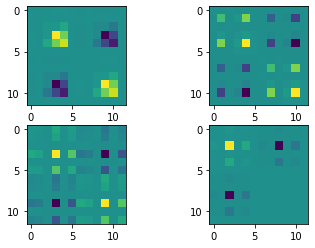

In [12]:
f, axarr = plt.subplots(2,2)

axarr[0,0].imshow(realisations_torch[0].cpu())
axarr[0,1].imshow(realisations_torch[1].cpu())
axarr[1,0].imshow(realisations_torch[2].cpu())
axarr[1,1].imshow(realisations_torch[3].cpu())

3D Surface of a FIM

TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


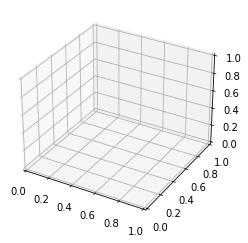

In [13]:
xx, yy = np.mgrid[0:realisations_torch[0].cpu().shape[0], 0:realisations_torch[0].cpu().shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, realisations_torch[0].cpu() ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

# show it
plt.show()

Eigenvalue Distribution of the Fisher Information Matrix

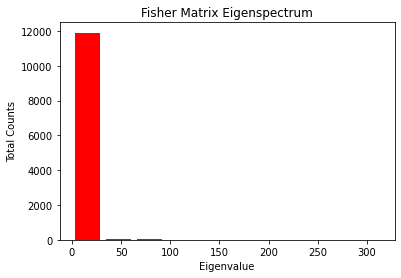

In [14]:
EV =[]
#normalise fisher
normalised_fishers = utils.fisher.normalise(realisations_torch.cpu())

#Calculate Positive Eigenvalues
for i in normalised_fishers:
    EV = np.append(EV,torch.eig(i, eigenvectors=False,  out=None)[0][:,0].detach().numpy())
#Plot Them
plt.subplot(111)
nbins = 10
plt.hist(EV, bins=nbins, rwidth=0.8, color='r')
plt.ylabel("Total Counts")
plt.xlabel("Eigenvalue")
plt.title("Fisher Matrix Eigenspectrum")
plt.show()

Rank Distribution of the Obtained Realisations of the Fisher Information Matrix

The Mean Rank obtained is 4.452 



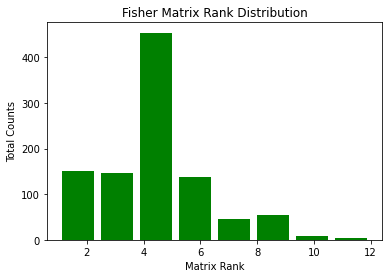

In [15]:
plt.subplot(111)
nbins = 8
plt.hist(Rank, bins=nbins, rwidth=0.8, color='g')
plt.ylabel("Total Counts")
plt.xlabel("Matrix Rank")
plt.title("Fisher Matrix Rank Distribution")
MeanRank = np.mean(Rank)
print(f"The Mean Rank obtained is {MeanRank} \n")
plt.savefig('VanillaRank.png')
plt.show()

Fisher Rao Norm Distribution

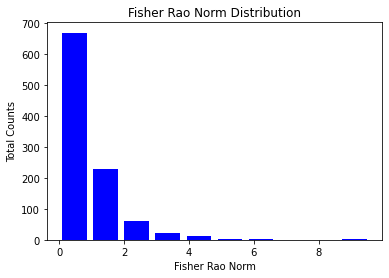

In [16]:
plt.subplot(111)
nbins = 10
FR2 = [np.abs(e) for e in FR]
plt.hist(FR2, bins=nbins, rwidth = 0.8 ,color='b')
plt.ylabel("Total Counts")
plt.xlabel("Fisher Rao Norm")
plt.title("Fisher Rao Norm Distribution")
plt.savefig('VanillaRao.png')
plt.show()